In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from bqplot import pyplot as plt
#from bqplot import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sns.set()

### Load data
The usual.

In [169]:
df = pd.read_csv('../data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1)

# __Curve fitting__ on piecewise components
Now on piecewise components of each cycle.

### Polynomial curve fit
Curve fit on increasing slope.

In [4]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
w, h = 12, 8

Select increasing-load side of each cycle.

In [5]:
c=25 # for example
start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
inc = df[df.Cycle==c].iloc[:(peak-start)]

In [6]:
X = inc.drop(['Load', 'Datetime'], axis=1).fillna(0)
y = inc.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X, y)
yh = model.predict(X)

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


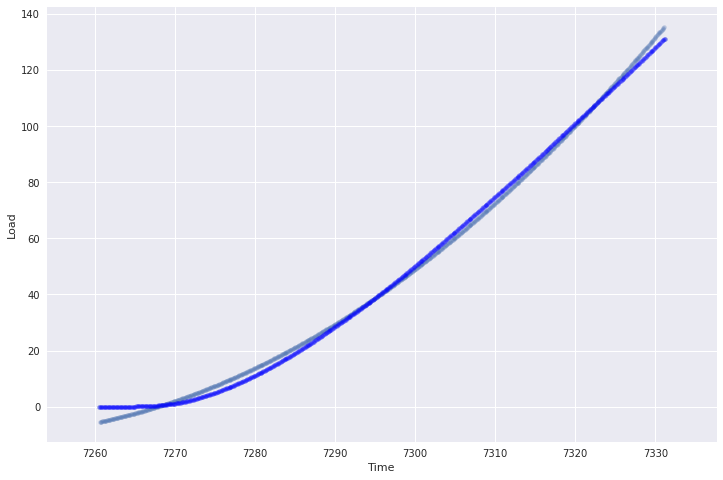

In [7]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, yh, fit_reg=False, ax=ax, scatter_kws={'s': 20, 'alpha': 0.3})
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})

In [8]:
np.sqrt(mse(yh, y))

2.0351358557326518

### Clustering and multiple regression
Not good enough. Let's try subdividing the heating portion of each cycle using clustering.

In [9]:
from sklearn.cluster import KMeans

In [10]:
km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
c = km.fit_predict(inc[['Time', 'Load']])
c0 = inc[np.logical_not(c)]
c1 = inc[c.astype(bool)];

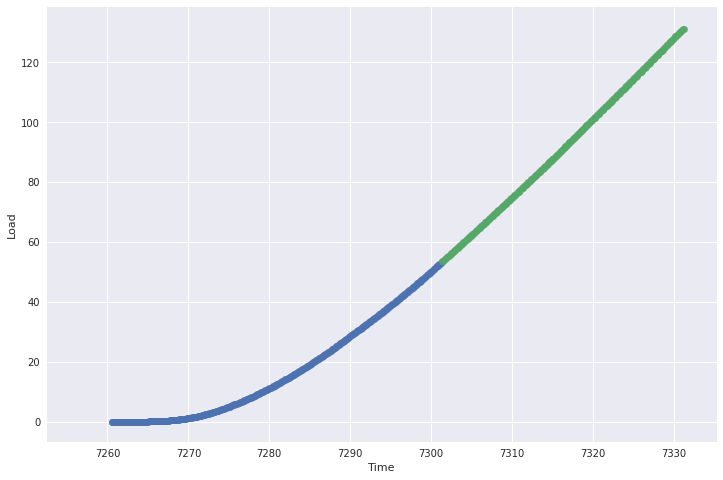

In [11]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot('Time', 'Load', c0, fit_reg=False, ax=ax)
sns.regplot('Time', 'Load', c1, fit_reg=False, ax=ax)
#sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 20, 'alpha': 0.2})

Now we fit curves to each cluster.

In [12]:
X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
y0 = c0.Load; y1 = c1.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X0, y0); yh0 = model.predict(X0)
model.fit(X1, y1); yh1 = model.predict(X1)

/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/nwchen/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


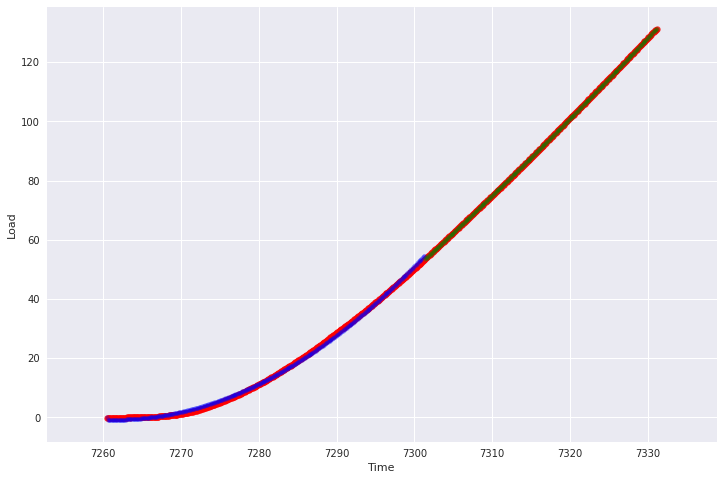

In [13]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 40, 'alpha': 0.8})
sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'green', 's': 20, 'alpha': 0.3})

Error is much better (less), but we have to deal with a discontinuity between clusters now.

In [14]:
np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))

(0.594636990360478, 0.067667266713464)

Now for all cycles.

In [15]:
import warnings
warnings.simplefilter("ignore", UserWarning)

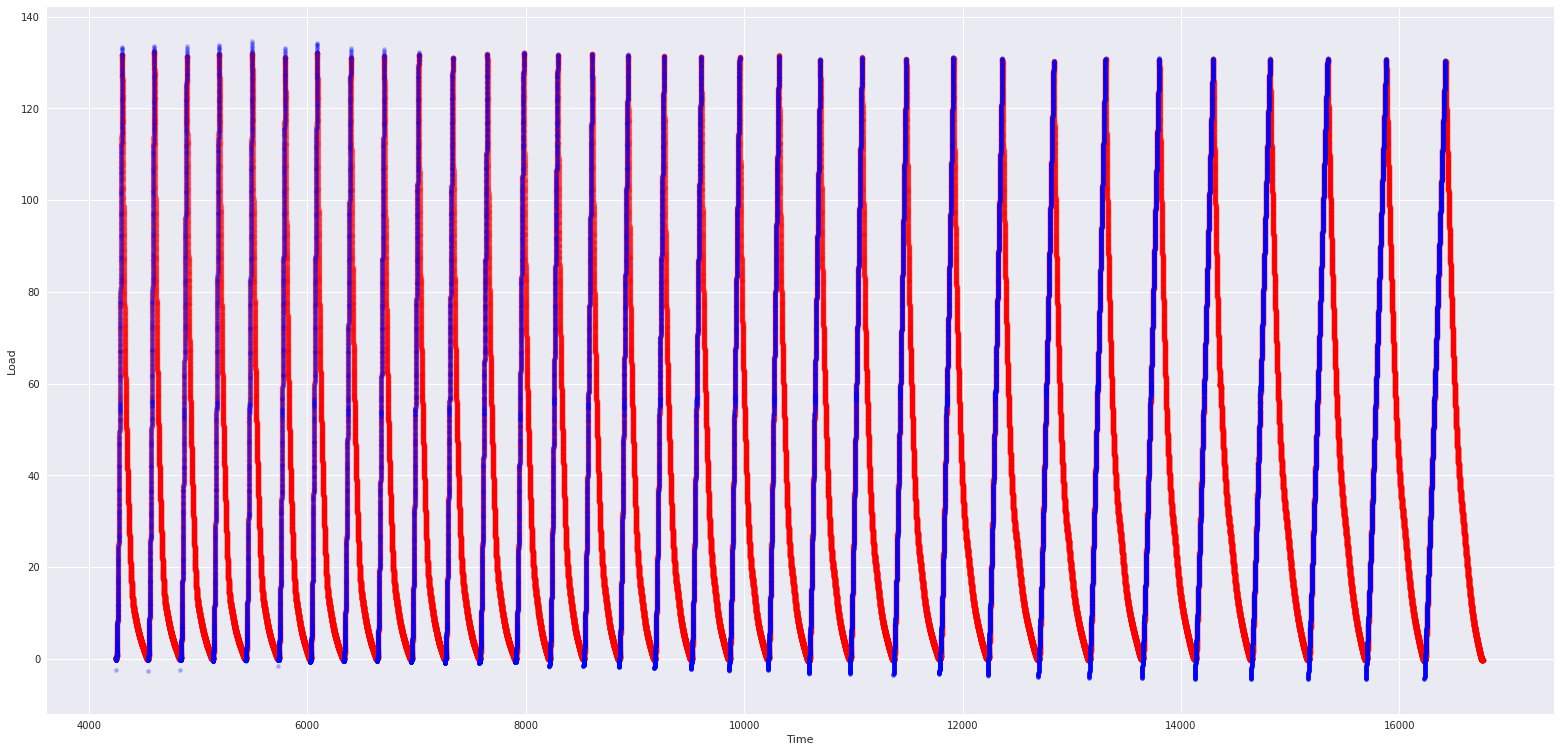

In [16]:
fig, ax = plt.subplots(figsize=(w+15,h+5))
rmses = []
df = df[df.Cycle > 14]
for c in np.nditer(df.Cycle.unique()):
    # delimit cycles
    start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
    peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
    inc = df[df.Cycle==c].iloc[:(peak-start)]
    
    # cluster cycle
    km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
    ch = km.fit_predict(inc[['Time', 'Load']])
    c0 = inc[np.logical_not(ch)]
    c1 = inc[ch.astype(bool)];
    
    # fit curve-before- and curve-after- knee
    X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0 = c0.Load; y1 = c1.Load
    model = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(X0, y0); yh0 = model.predict(X0)
    model.fit(X1, y1); yh1 = model.predict(X1)
    
    X = df[df.Cycle==c]
    sns.regplot(X.Time, X.Load, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 30, 'alpha': 0.3})
    sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    rmses.append((np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))))

Now the same for the decreasing (cooling) side.

In [17]:
c=25 # for example
peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
end = df[df.Cycle==c].tail(1).index.values[0]
dec = df[df.Cycle==c].iloc[(peak-start):(end-start)]

In [18]:
X = dec.drop(['Load', 'Datetime'], axis=1).fillna(0)
y = dec.Load
model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(X, y)
yh = model.predict(X)

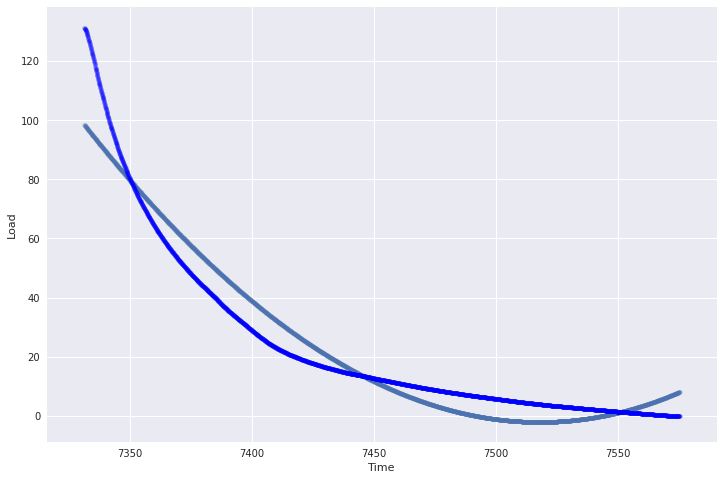

In [19]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, yh, fit_reg=False, ax=ax, scatter_kws={'s': 20, 'alpha': 0.3})
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})

Clearly not so great - we try clustering again.

In [20]:
km = KMeans(n_clusters=2).fit(dec[['Time', 'Load']])
c = km.fit_predict(dec[['Time', 'Load']])
c0 = dec[np.logical_not(c)]
c1 = dec[c.astype(bool)];

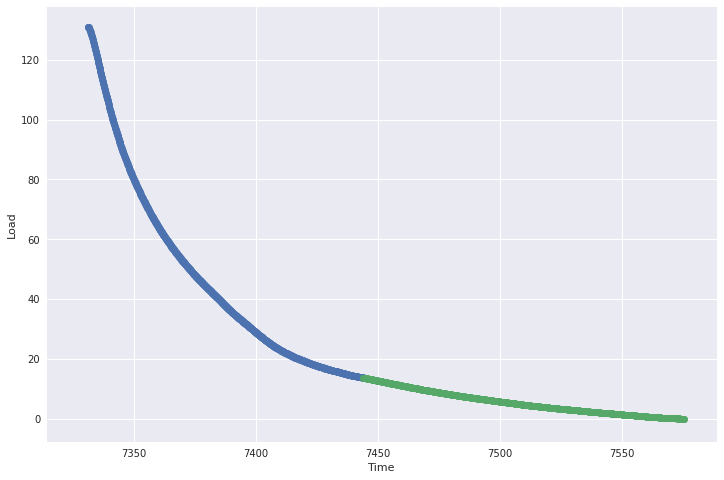

In [21]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot('Time', 'Load', c0, fit_reg=False, ax=ax)
sns.regplot('Time', 'Load', c1, fit_reg=False, ax=ax)

In [22]:
X0 = c0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1 = c1.drop(['Load', 'Datetime'], axis=1).fillna(0)
y0 = c0.Load; y1 = c1.Load
model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(X0, y0); yh0 = model.predict(X0)
model.fit(X1, y1); yh1 = model.predict(X1)

/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0517445667841714e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7682997574853718e-23 / 1.1102230246251565e-16
  RuntimeWarning)


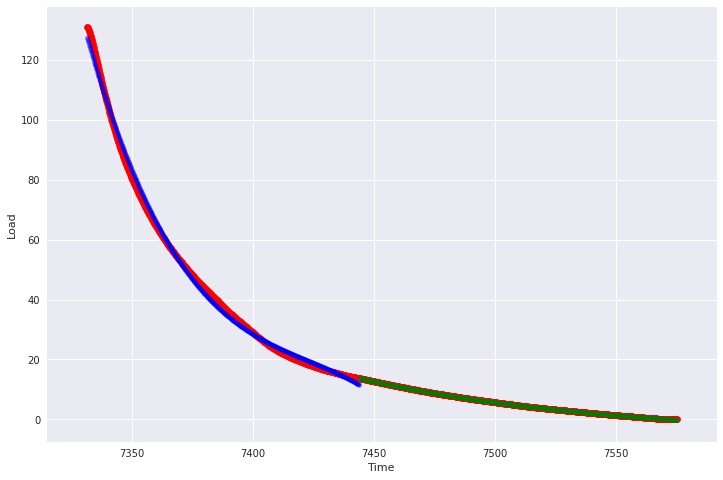

In [23]:
fig, ax = plt.subplots(figsize=(w,h))
sns.regplot(X.Time, y, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 40, 'alpha': 0.8})
sns.regplot(X0.Time, yh0, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
sns.regplot(X1.Time, yh1, fit_reg=False, ax=ax, scatter_kws={'color': 'green', 's': 20, 'alpha': 0.3})

Not bad, even with just a 3rd-degree polynomial fit.

In [24]:
np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))

(1.6984987238287221, 0.030263056648037044)

Putting it all together (no inference).

In [25]:
np.seterr(all='ignore'); # for reading convenience

In [26]:
inc_coefs = pd.DataFrame()
inc_intercepts = pd.DataFrame()
dec_coefs = pd.DataFrame()
dec_intercepts = pd.DataFrame()

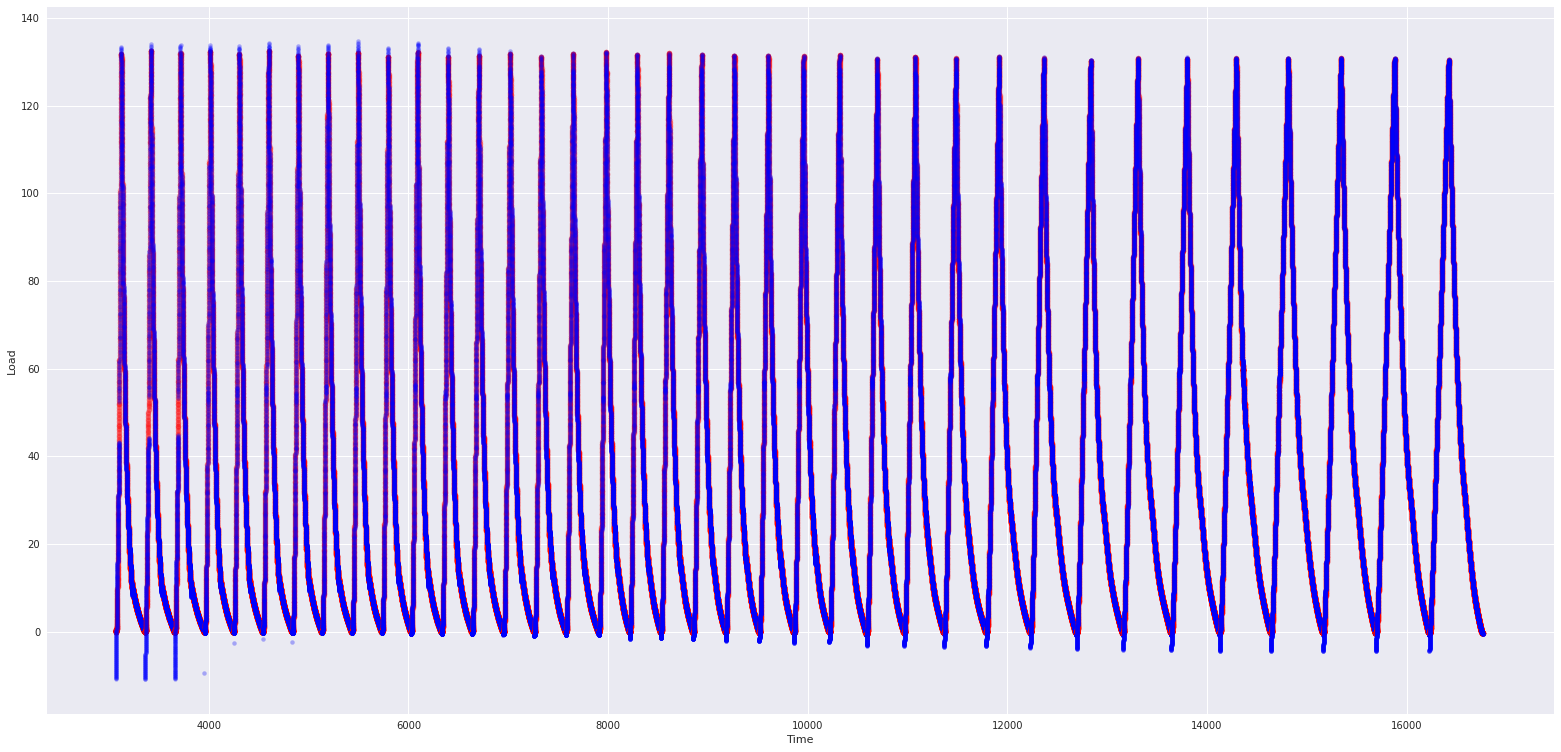

In [217]:
fig, ax = plt.subplots(figsize=(w+15,h+5))
rmses = []
df = df[df.Cycle > 10] # tune 35? for speed
for c in np.nditer(df.Cycle.unique()):
    # delimit cycles
    start = df[(df.Cycle==c) & (df.Min==1)].index.values[0]
    peak = df[(df.Cycle==c) & (df.Max==1)].index.values[0]+1
    inc = df[df.Cycle==c].iloc[:(peak-start)]
    end = df[df.Cycle==c].tail(1).index.values[0]
    dec = df[df.Cycle==c].iloc[(peak-start):(end-start)]
    
    # cluster cycle, increasing
    km = KMeans(n_clusters=2).fit(inc[['Time', 'Load']])
    ch = km.fit_predict(inc[['Time', 'Load']])
    ic0 = inc[np.logical_not(ch)]
    ic1 = inc[ch.astype(bool)];
    
    # cluster cycle, decreasing
    km = KMeans(n_clusters=2).fit(dec[['Time', 'Load']])
    ch = km.fit_predict(dec[['Time', 'Load']])
    dc0 = dec[np.logical_not(ch)]
    dc1 = dec[ch.astype(bool)];
    
    # fit curve-before- and curve-after- knee, increasing
    X0i = ic0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1i = ic1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0i = ic0.Load; y1i = ic1.Load
    model = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(X0i, y0i); yh0i = model.predict(X0i)
    model.fit(X1i, y1i); yh1i = model.predict(X1i)
    inc_coefs = inc_coefs.append(pd.Series(model.named_steps['ridge'].coef_), ignore_index=True)
    inc_intercepts = inc_intercepts.append(pd.Series(model.named_steps['ridge'].intercept_), ignore_index=True)
    
    # fit curve-before and curve-after- knee, decreasing
    X0d = dc0.drop(['Load', 'Datetime'], axis=1).fillna(0); X1d = dc1.drop(['Load', 'Datetime'], axis=1).fillna(0)
    y0d = dc0.Load; y1d = dc1.Load
    model = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(X0d, y0d); yh0d = model.predict(X0d)
    model.fit(X1d, y1d); yh1d = model.predict(X1d)
    dec_coefs = dec_coefs.append(pd.Series(model.named_steps['ridge'].coef_), ignore_index=True)
    dec_intercepts = dec_intercepts.append(pd.Series(model.named_steps['ridge'].intercept_), ignore_index=True)
    
    X = df[df.Cycle==c]
    sns.regplot(X.Time, X.Load, fit_reg=False, ax=ax, scatter_kws={'color': 'red', 's': 30, 'alpha': 0.3})
    sns.regplot(X0i.Time, yh0i, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1i.Time, yh1i, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X0d.Time, yh0d, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    sns.regplot(X1d.Time, yh1d, fit_reg=False, ax=ax, scatter_kws={'color': 'blue', 's': 20, 'alpha': 0.3})
    #rmses.append((np.sqrt(mse(yh0, y0)), np.sqrt(mse(yh1, y1))))

In [30]:
model.named_steps['polynomialfeatures'].transform(X0d).shape

(1773, 560)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

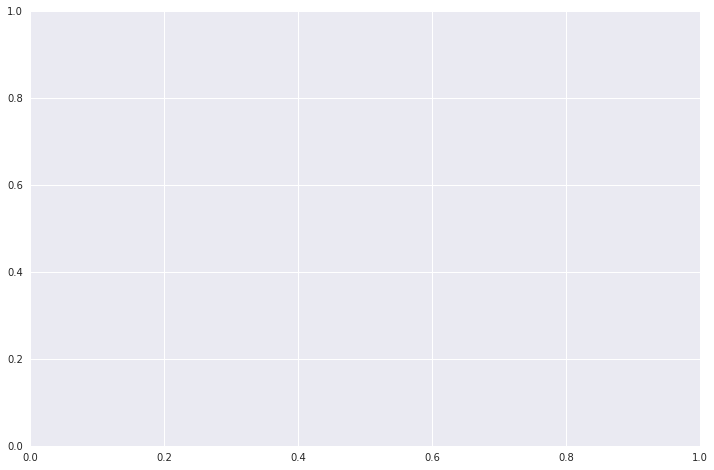

In [99]:
fig, ax = plt.subplots(figsize=(w, h))
for i in dec_coefs.columns.values.tolist():
    if dec_coefs[i].min() > -0.5:
        sns.regplot(np.arange(33), dec_coefs[i], ax=ax)

# __Prediction performance__ on other features
The curves generated above take a $560$-d polynomial feature matrix generated from the existing feature matrix. 
We can reduce the dimensionality of this prediction problem by selecting the most heavily weighted features:
`Load`, `Heating`, `Cooling`, `Kurtosis`, `Belly`, `Period`.

In [32]:
from sklearn.feature_selection import RFE

In [33]:
rfe = RFE(model.named_steps['ridge'], n_features_to_select=5)
rfe.fit(X0d, y0d) # use the most recent training datasets
print(rfe.ranking_, rfe.support_)
print(X0d.columns[rfe.support_])

[1 9 8 7 6 5 4 3 2 1 1 1 1] [ True False False False False False False False False  True  True  True
  True]
Index(['Time', 'Tail', 'Belly', 'Kurt', 'Skew'], dtype='object')


In [34]:
rfe = RFE(model.named_steps['ridge'], n_features_to_select=5)
rfe.fit(X0i, y0i) # use the most recent training datasets
print(rfe.ranking_, rfe.support_)
print(X0i.columns[rfe.support_])

[1 4 9 8 1 3 1 7 1 2 1 5 6] [ True False False False  True False  True False  True False  True False
 False]
Index(['Time', 'Area', 'Cooling', 'Period', 'Belly'], dtype='object')


In [35]:
df.columns

Index(['Time', 'Load', 'Datetime', 'Min', 'Max', 'Cycle', 'Area', 'Heating',
       'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew'],
      dtype='object')

## __Regression__ on `Area` alone
Simple polynomial fit.

In [235]:
df = pd.read_csv('../data/cycles-with-features.csv', header=0).drop(labels='Unnamed: 0', axis=1)
df = df[df.Cycle >= 1].reset_index().drop('index', axis=1)

In [37]:
training = 37
features = ['Time', 'Load', 'Min', 'Max', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']

for feature in features:
    t_features = features[:]
    t_features.remove(feature)
    X = df[(df.Cycle<training) & (df.Min==1)].fillna(0)
    
    model = make_pipeline(PolynomialFeatures(include_bias=False), Ridge())
    model.fit(X[t_features], X[feature])
    
    #if features not in ['Load', ] # these values don't follow a linear trend
    score = model.score(df[(df.Min==1) & (df.Cycle > training)][t_features], df[(df.Min==1) & (df.Cycle > training)][feature])
    print(feature, '%.2f'%score)

/home/nwchen/.local/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0825276288736325e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Time -52.08
Load -653631.94
Min 1.00
Max 1.00
Cycle -16.89
Area 0.98
Heating 0.99
Cooling -51.50
HCprop -0.61
Period 0.95
Tail -8.45
Belly -2.45
Kurt -439.29
Skew -20.63


We may achieve better performance by tuning regression parameters.

In [38]:
np.warnings.filterwarnings('ignore')

In [198]:
scores = {}
training = 37

for alpha in np.linspace(0.0, 2.0, 10):
    for degree in [2, 3, 5]:
        for feature in features:
            t_features = features[:]
            t_features.remove(feature)
            X = df[(df.Cycle<training) & (df.Min==1)].fillna(0)

            model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), Ridge(alpha=alpha))
            model.fit(X[t_features], X[feature])

            if feature not in ['Load', 'Min', 'Max']: # these values don't follow a linear (or important) trend
                score = model.score(df[(df.Min==1) & (df.Cycle > training)][t_features], df[(df.Min==1) & (df.Cycle > training)][feature])
                
                if feature in scores.keys():
                    if score > scores[feature]:
                        scores[feature] = score
                else:
                    scores[feature] = score
                #print('a=%f, d=%d, feature=%s, score=%f' % (alpha, degree, feature, score))
print(scores)

{'Heating': 0.947773640213736, 'HCprop': 0.8686499245446311, 'Tail': -19.409888126383816, 'Time': 0.8162797821759271, 'Kurt': -664.9165751360741, 'Cooling': -18.92455675113287, 'Belly': -177.87338100039761, 'Skew': -0.7838747107796523, 'Area': 0.9771043431376739, 'Cycle': -9.582545790852615, 'Period': 0.6204846264572556}


# __March__ 12

# Automation via _GridSearchCV_

In [58]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, TimeSeriesSplit

`features` is a set of features to use as targets, __not__ as training features.

In [130]:
#features = ['Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']
features = ['Time', 'Load', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']

In [220]:
ests = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
param_grid = {
    'alpha': np.linspace(0.01, 10.0, 30)
    #'warm_start': [True, False]
}
scores = {}
best_est = {}
tscv = TimeSeriesSplit(n_splits=5)

# HOTFIX
X=df[df.Min==1].drop(['Datetime'], axis=1).fillna(0)

for feature in features:
    cv = None
    for i, est in enumerate(ests):
        #t_features = features[:]; t_features.remove(feature)
        t_features = ['Time', 'Cycle']
        y = X[feature]
        
        # run gridsearch cross-validation
        if i == 0:
            cv = GridSearchCV(est, {}, cv=tscv, refit=True).fit(X[t_features], y)
        else:
            cv = GridSearchCV(est, param_grid, cv=tscv, refit=True).fit(X[t_features], y)
        score = cv.score(X[t_features], y)
        
        # enumerate scores by features
        if feature in scores.keys():
            scores[feature].append(score)
        else:
            scores[feature] = [score]
            
        # store the best estimator for curve generation later
        if feature not in best_est.keys():
            best_est[feature] = (None, 0) # default score
        elif score > best_est[feature][1]: # best score
            best_est[feature] = (cv.best_estimator_, score)

    #best_est[feature] = (ests[scores[feature].index(max(scores[feature]))],\
    #                     max(scores[feature])) #(cv.best_estimator_, cv.best_score_, scores[feature])

In [175]:
best_est

{'Area': (Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False), 0.9529994822407566),
 'Belly': (Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  0.7163577990481618),
 'Cooling': (Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  0.568908566380669),
 'Cycle': (Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  0.9999999998279494),
 'HCprop': (Ridge(alpha=7.244137931034483, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  0.7326319500249262),
 'Heating': (Lasso(alpha=1.0434482758620691, copy_X=True, fit_intercept=True,
     ma

## __Grid-search cross-validation__ results

In [176]:
import pprint; pprint.PrettyPrinter().pprint(scores)

{'Area': [0.9530028884533428,
          0.9510367194507692,
          0.9529994822407566,
          0.9396838343612613],
 'Belly': [0.716427690441949,
           0.7163577990481618,
           0.7163412601604966,
           0.7138048332475885],
 'Cooling': [0.5698267875203029,
             0.568908566380669,
             0.5680338092004815,
             0.5673016288510838],
 'Cycle': [1.0, 0.9999999998279494, 0.9999970461711505, 0.999997078255041],
 'HCprop': [0.7329262520203903,
            0.7326319500249262,
            0.7262435670442369,
            0.7312139254087282],
 'Heating': [0.9343600302184967,
             0.932677351540516,
             0.9338754351848818,
             0.9288326123317031],
 'Kurt': [0.8541131057105811,
          0.8541131055792193,
          0.8481698402674318,
          0.8540669930075202],
 'Load': [0.29346152689619664,
          0.29346112443748157,
          0.278598951687655,
          0.292515386955419],
 'Period': [0.7742550748656246,
            

## __Curve generation__ from predicted features

In [225]:
def curve_gen(est, n, t, f_ests):
    """
    Args:
        est: an `sklearn` estimator fit to {features\{Load, Time}}
          n: which cycle # to predict (constant)
          t: the time at which to start this cycle
     f_ests: estimators (already fit) for all other features
    
    Returns:
        matrix of Load against Time (starting at 0 - remember to offset this)
    """
    features = ['Time', 'Load', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']
    X = {}
    for feature in features:
        f_est = f_ests[feature][0] # f_est = the best estimator for `feature`
        x = pd.DataFrame( # inputs for the next (to be generated) cycle
            [[t, n]], columns=['Time', 'Cycle']
        )
        X[feature] = f_est.predict(x)[0]

    X = pd.DataFrame(X, index=[0]).drop(['Load'], axis=1)
    print(X.shape)
    return est.predict(X)

In [227]:
model = make_pipeline(PolynomialFeatures(degree=5), Ridge())

### Increasing/decreasing-load trainng set

Helper methods for isolating heating/cooling subsets of cycles

In [249]:
# Helper methods for isolating heating/cooling subsets of cycles.
def inc(cycle_df):
    start = cycle_df[cycle_df.Min==1].Time.values[0]
    end = cycle_df[cycle_df.Max==1].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

def dec(cycle_df):
    start = cycle_df[cycle_df.Max==1].Time.values[0]
    end = cycle_df.iloc[-1:].Time.values[0]
    return cycle_df[(cycle_df.Time > start) & (cycle_df.Time < end)]

Generate increasing-load and decreasing-load datasets

In [1]:
df_inc = pd.DataFrame()
df_dec = pd.DataFrame()
for cycle in np.arange(1, 47):
    cycle_df = df[df.Cycle==cycle].reset_index()    
    df_inc = df_inc.append(inc(cycle_df), ignore_index=True)
    df_dec = df_dec.append(dec(cycle_df), ignore_index=True)

NameError: name 'pd' is not defined

What do they look like?

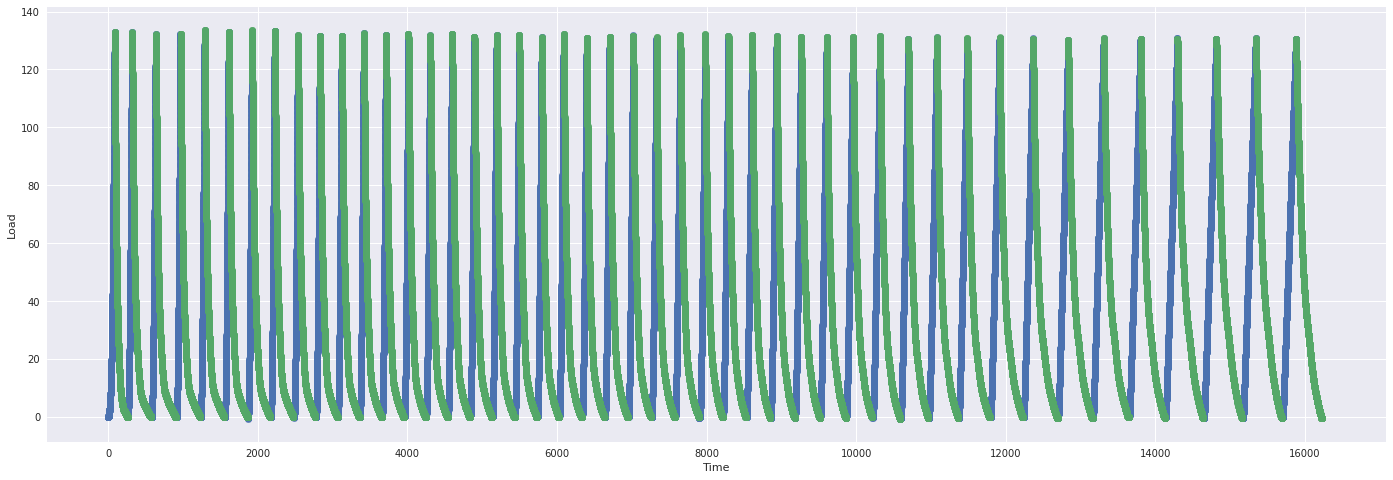

In [271]:
fig, axes = plt.subplots(figsize=(w*2, h))
sns.regplot('Time', 'Load', df_inc, ax=axes, fit_reg=False)
sns.regplot('Time', 'Load', df_dec, ax=axes, fit_reg=False)

In [ ]:
cycle = 45
start = df[(df.Cycle==cycle) & (df.Min==1)].Time.values[0]
load = []
for t in range(int(start), int(start+100)):
    load.append(curve_gen(model, cycle, t, best_est)) # TODO feed a new (more recent) `model`

In [ ]:
plt.plot(np.arange(int(start), int(start+100)), load)

## Further tuning
Some (most) features require no polynomial data augmentation.

In [42]:
from sklearn.preprocessing import Imputer

In [45]:
scores = {}
training = 37
features = ['Time', 'Load', 'Cycle', 'Area', 'Heating', 'Cooling', 'HCprop', 'Period', 'Tail', 'Belly', 'Kurt', 'Skew']

for alpha in np.linspace(0.1, 3.0, 10):
    for degree in [1, 2, 3, 5]:
        for feature in features:
            for bias in [True, False]:
                t_features = features[:]
                t_features.remove(feature)

                X = df[(df.Cycle<training) & (df.Min==1)][features].iloc[1:,].reset_index(drop=True)

                # Imputer(missing_values=-1, strategy="mean", axis=0), 
                model = make_pipeline( PolynomialFeatures(degree=degree, include_bias=bias), Ridge(alpha=alpha, random_state=0) )
                model.fit(X[t_features], X[feature])

                if feature not in ['Load', 'Min', 'Max']: # these values don't follow a linear (or important) trend
                    
                    
                    score = model.score(df[(df.Min==1) & (df.Cycle > training)][t_features], df[(df.Min==1) & (df.Cycle > training)][feature])

                    if feature in scores.keys():
                        if score > scores[feature]:
                            scores[feature] = score
                    else:
                        scores[feature] = score
                    #print('a=%f, d=%d, feature=%s, score=%f' % (alpha, degree, feature, score))
print(scores)

{'Heating': 0.9999973147516348, 'HCprop': 0.9846371528783963, 'Tail': 0.9999994773803766, 'Time': 0.9658290892772616, 'Kurt': -11.132898840349146, 'Cooling': 0.9999994649616728, 'Belly': -1.1082070077056678, 'Skew': -1.1061445892292756, 'Area': 0.973199549921112, 'Cycle': 0.8356647304478368, 'Period': 0.9999979495184118}


## Data leakage
__HCprop__, __Heating__, __Cooling__, __Period__, __Tail__ all leak data onto each other, warping model performance. __Cycle__ has no reason to perform below `R^2=0.99`.

In [ ]:
leakers = ['HCprop', 'Heating', 'Cooling', 'Period']
for l in leakers:
model = make_pipeline( PolynomialFeatures(degree=degree, include_bias=bias), Ridge(alpha=alpha, random_state=0) )

In [ ]:
# returns a y-matrix with shape (X.shape[0], 1), where X is data for a single cycle
def gen(X, M, b): # X = (n, _); m = a subset of all coefs, e.g .(p=1, q=560); b = (p=33, 1); map 
    return X.apply(lambda x: M.apply(\
                    lambda m: m*x, axis=0),\
                   axis=1)
                   
                   sum over all row-elements in m*x, + b)
    for i, x in X.iterrows():
        
    #return x.apply(lambda f: , axis=1)

In [ ]:
dec_coefs.head()

# __Generating new curves__ from clustering + regression

In [ ]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
dc_red = pca.fit_transform(scale(dec_coefs)) # dc = dec_coefs = decreasing-side coeffs

The first $5$ components explain most of the variance in the data.

In [ ]:
pca.explained_variance_ratio_.shape

In [ ]:
scale(dec_coefs).